In [85]:
# from core import load_metrics, generate_population, tournament_selection, fixed_crossover, mutate, replace_weakest
from core.utils import load_metrics, generate_population, tournament_selection, binary_tournament
from core.crossover import fixed_crossover, fixed_crossover_twopoint , ordered_crossover, partialMap_crossover
from core.mutation import mutate, multiple_mutate, inversion, scramble
from core.replacement import replace_firstweak, replace_weakest
from core.visualization import draw_cost, draw_cost_seperate
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [86]:
sample = [
    [0,2,1,2,1],
    [2,0,2,2,2],
    [1,2,0,2,1],
    [2,2,2,0,2],
    [1,2,1,2,0]
]

### Chromosome Class

In [87]:
from core import fitness
from typing import List, Callable

class Chromosome:
    def __init__(self, genes:List[int]):
        self.genes = genes
        self.phenomes = self.__fitness__(genes=genes)

    def __fitness__(self, genes:List[int]) -> int:
        return fitness(genes, distance_metric=sample)

    def __str__(self):
        return f"Genes: {self.genes}\nPhenomes: {self.phenomes:.5f}"


### Genetic class

In [88]:
class GENETIC4TSP(nn.Module):
    def __init__(self,
                max_generations:int,
                population_size:int,
                tournament_size:int,
                p_mutation:float,
                p_crossover:float,
                mutate_fn,
                crossover_fn,
                # mutate_fn:Callable[[List[int]],List[int]],
                # crossover_fn:Callable[[(List[int],List[int])],(List[int],[List[int]])],
                replace_fn) -> None:
        super().__init__()
        self.max_generations = max_generations
        self.population_size = population_size
        self.tournament_size = tournament_size
        self.p_mutation = p_mutation
        self.p_crossover = p_crossover
        self.mutate_fn = mutate_fn
        self.crossover_fn = crossover_fn
        self.replacement_fn = replace_fn
        self.first_population = None
        self.first_fitness = None
        self.avg_fitness = []
        self.highest_fitness = []
    
    def __str__(self) -> str:
        return f"""
            Genetic Algorithm for TSP\n==Parameter==\nmax_generations: {self.max_generations}\npopulation size: {self.population_size}\ntournament size: {self.tournament_size}\np_mutation: {self.p_mutation}\np_crossover: {self.p_crossover}\nmutate function: {str(self.mutate_fn)}\ncrossover function: {self.crossover_fn}\nrepalcement function: {str(self.replacement_fn)}
            """
        
    def forward(self, x):
        assert len(x) == len(x[0]), "metric should be symmetric"
        return self.search(x)

    def search(self, distance_metric):
        population_sample = generate_population(distance_metric=distance_metric, pop_size=self.population_size)
        self.first_population = population_sample
        population_fitness = [fitness(pop, distance_metric=distance_metric) for pop in population_sample]
        self.first_fitness = population_fitness
        self.highest_fitness.append(np.max(population_fitness))
        self.avg_fitness.append(np.mean(population_fitness))
        for _ in range(self.max_generations):
            parent1, parent2 = binary_tournament(population=population_sample, fitness_value=population_fitness, tournament_size=self.tournament_size)
            child1 , child2 = self.crossover_fn(parent1=parent1, parent2=parent2)
            child1 , child2 = self.mutate_fn(child1) , self.mutate_fn(child2)
            population_sample = replace_firstweak(population=population_sample,candidate=child1,distance_metric=distance_metric)
            population_sample = replace_firstweak(population=population_sample,candidate=child2,distance_metric=distance_metric)
            population_fitness = [fitness(pop, distance_metric=distance_metric) for pop in population_sample]
            self.highest_fitness.append(np.max(population_fitness))
            self.avg_fitness.append(np.mean(population_fitness))
        return population_sample, population_fitness


In [89]:
test01 = GENETIC4TSP(100,10,4,.9,.2,mutate_fn=mutate,crossover_fn=fixed_crossover,replace_fn=replace_weakest)

In [90]:
res01 = test01(sample)

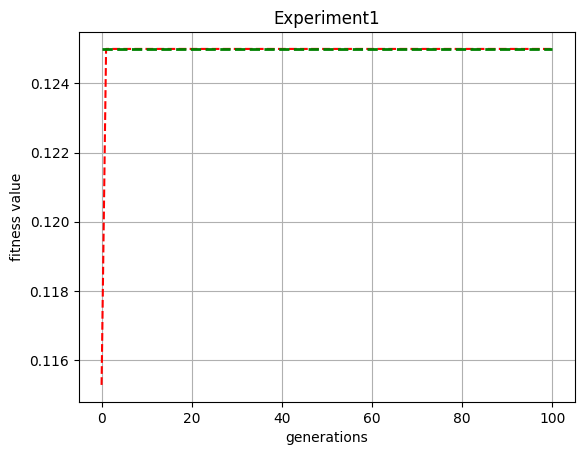

In [91]:
draw_cost(test01.highest_fitness, test01.avg_fitness)

### search function

In [92]:
def binary_tournament(population,fitness_value, tournament_size):
    parent1, _ = tournament_selection(population=population, fitness_value=fitness_value, tournament_size=tournament_size)
    parent2, _ = tournament_selection(population=population, fitness_value=fitness_value, tournament_size=tournament_size)
    return parent1 , parent2

In [93]:
def search(max_gens, pop_size, tour_size, co_fn, mut_fn):
    population = generate_population(distance_metric=sample, pop_size=pop_size)
    pop_fitness = [fitness(pop, distance_metric=sample) for pop in population]
    fit_avg = [np.mean(pop_fitness)]
    fit_upper = [np.max(pop_fitness)]
    for i in range(max_gens):
        # parent1 = tournament_selection(population=population, fitness_value=pop_fitness, tournament_size=tour_size)
        parent1, parent2 = binary_tournament(population=population, fitness_value=pop_fitness, tournament_size=tour_size)
        child1 , child2 = co_fn(parent1=parent1, parent2=parent2)
        child1 , child2 = mut_fn(child1) , mut_fn(child2)
        population = replace_firstweak(population=population,candidate=child1,distance_metric=sample)
        population = replace_firstweak(population=population,candidate=child2,distance_metric=sample)
        pop_fitness = [fitness(pop, distance_metric=sample) for pop in population]
        fit_avg.append(np.mean(pop_fitness))
        fit_upper.append(np.max(pop_fitness))
        if i > 2:
            if fit_avg[i] - fit_avg[i-1]:
                print(f"improve avg fitness from {fit_avg[i-1]} -> {fit_avg[i]}")

    return population, pop_fitness , fit_avg, fit_upper


### Experiments

Experiment01

In [94]:
max_gens = 100
pop_size = 10
tour_size = 4
mutate_fn = mutate
crossover_fn = fixed_crossover

pop1 , pop_fit1 , avg1 , upper1 , lower1 = search(
    max_gens=max_gens,
    pop_size=pop_size,
    tour_size=tour_size,
    mut_fn=mutate_fn,
    co_fn=crossover_fn
    )


ValueError: not enough values to unpack (expected 5, got 4)

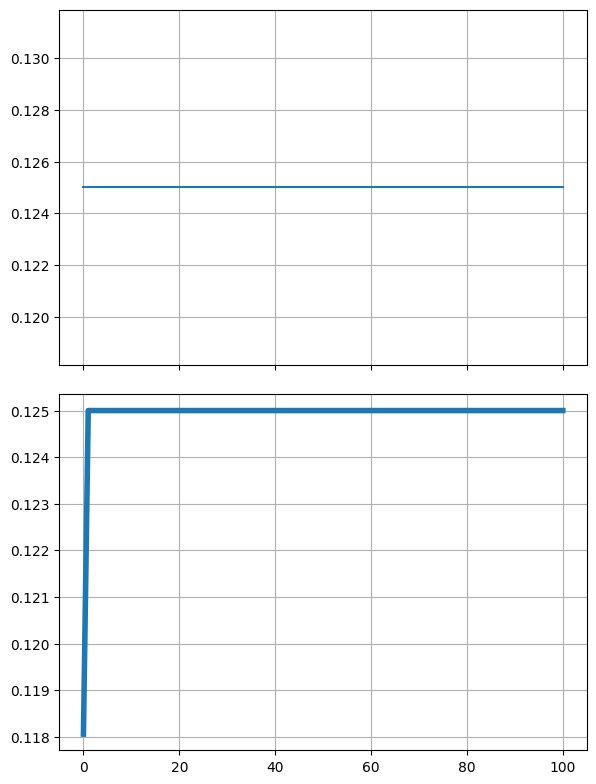

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6,8), sharex=True)
x = list(range(len(upper1)))
fig.tight_layout()
ax[0].plot(x, upper1)
ax[1].plot(x, avg1,linewidth=4.0)
for a in ax:
    a.grid()

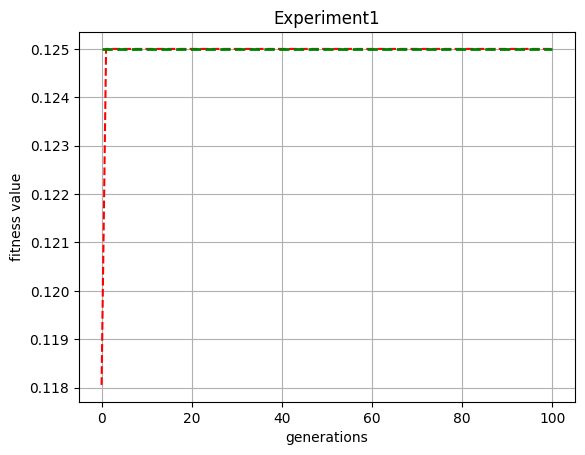

In [ ]:
plt.plot(x, avg1, linestyle='--', color='red')
plt.plot(x, upper1, linestyle='--',color='g',linewidth=2.0)
plt.title("Experiment1")
plt.xlabel('generations')
plt.ylabel('fitness value')
plt.grid()
plt.show()

### Experiment02

In [ ]:
sample

[[0, 2, 1, 2, 1],
 [2, 0, 2, 2, 2],
 [1, 2, 0, 2, 1],
 [2, 2, 2, 0, 2],
 [1, 2, 1, 2, 0]]

In [ ]:
burma_path = './dataset/burma14.xml'
brazil_path = './dataset/brazil58.xml'
burma_metric = load_metrics(burma_path)
brazil_metric = load_metrics(brazil_path)

d:\USERS\Exeter\Courses\Module ECMM409 (2023) Nature-Inspired Computation\Nature_inspired\project01\core\utils.py:16: RuntimeWarning: invalid value encountered in multiply
  weights_metric = np.nan_to_num(np.identity(num_node) * -np.inf, 0.0)


In [ ]:
G2 = GENETIC4TSP(
    1000,100,10,0.9,0.2,mutate,ordered_crossover,replace_weakest
)
print(G2)


            Genetic Algorithm for TSP
==Parameter==
max_generations: 1000
population size: 100
tournament size: 10
p_mutation: 0.9
p_crossover: 0.2
mutate function: <function mutate at 0x0000021C2C989580>
crossover function: <function ordered_crossover at 0x0000021C0E0174C0>
repalcement function: <function replace_weakest at 0x0000021C2C9DBCE0>
            


In [ ]:
result_sample = G2.forward(sample)
result_burma = G2.forward(burma_metric)
result_brazil = G2.forward(brazil_metric)

In [ ]:
print(max(result_sample[1]))
print(max(result_burma[1]))
print(max(result_brazil[1]))

0.125
0.00029976019184652276
2.2173932325158542e-05


In [ ]:
len(G2.avg_fitness[:1001])

1001

In [ ]:
len(G2.avg_fitness[1001:2002])

1001

In [ ]:
len(G2.avg_fitness[2002:3003])

1001

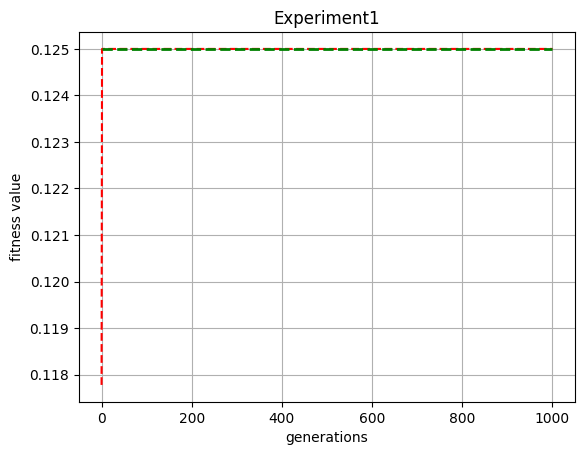

In [ ]:
draw_cost(G2.highest_fitness[:1001],G2.avg_fitness[:1001])

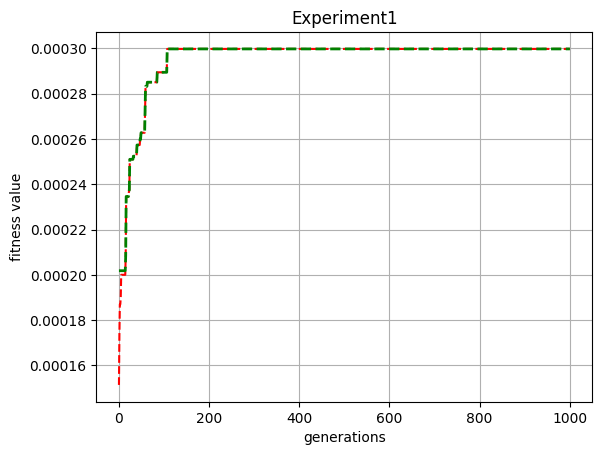

In [ ]:
draw_cost(G2.highest_fitness[1001:2002],G2.avg_fitness[1001:2002])

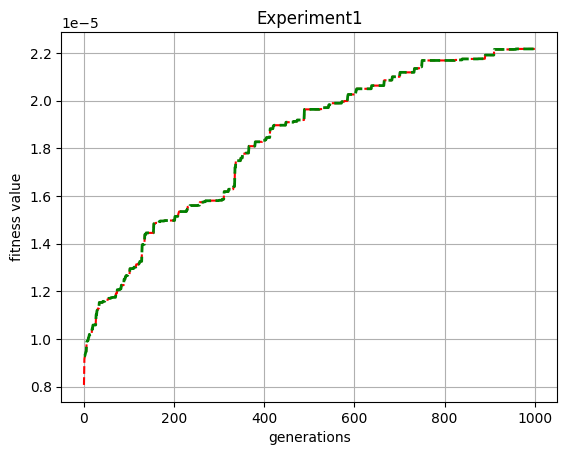

In [ ]:
draw_cost(G2.highest_fitness[2002:3003],G2.avg_fitness[2002:3003])

In [ ]:
1/(2.2e-5)

45454.545454545456

### Experiment03

In [ ]:
max_generations = [10,100,500,1000,10000]
population_sizes = [10,100,1000]
def tour_size_manager(pop_size):
    if (pop_size >= 100):
        return [pop_size*0.1,pop_size*0.2,pop_size*0.3,pop_size*0.8]
    else:
        return [2,4,6,8]
crossover_functions = [fixed_crossover, fixed_crossover_twopoint, ordered_crossover, partialMap_crossover]
mutate_functions = [mutate,multiple_mutate,inversion,scramble]
replace_functions = [replace_firstweak, replace_weakest]

In [ ]:
import xml.etree.ElementTree as ET
# function to load weight metrics
def load_metrics(xml_path, info=False):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # meta-data
    name = root.find('name').text
    source = root.find('source').text
    description = root.find('description').text
    doublePrecision = int(root.find('doublePrecision').text)
    ignoredDigits = int(root.find('ignoredDigits').text)
    num_node = len(root.findall(".//vertex"))
    # weights_metric = np.nan_to_num(np.identity(num_node) * -np.inf, 0.0)
    weights_metric = np.zeros(num_node)

    for i, vertex in enumerate(root.findall('.//vertex')):
        for edge in vertex.findall('.//edge'):
            cost = float(edge.get("cost"))
            node = int(edge.text)
            # print(f"line:{i} node:{node}->cost:{cost}")
            # if i == node:
            #     weights_metric[i,node] = -np.Inf
            # else:
            weights_metric[i][node] = cost
    if info is True:
        return weights_metric , (name, source, description, doublePrecision, ignoredDigits)

    return weights_metric

In [ ]:
x1 = [0,3,4,2,1]
x2 = [0,4,2,3,1]

In [ ]:
#test cross with fix
def fixed_crossover(arg1, arg2):
    assert len(arg1) == len(arg2) , "parents' size should be equal"
    n = len(arg1)
    # point = np.random.randint(n)
    point = 3
    child1 = [None] * n
    child2 = [None] * n
    child1[point:] = arg2[point:]
    child2[point:] = arg1[point:]

    for i in range(point):
        if arg1[i] not in child1:
            child1[i] = arg1[i]
        if arg2[i] not in child2:
            child2[i] = arg2[i]

    remain1 = [x for x in arg1 if x not in child1]
    remain2 = [x for x in arg2 if x not in child2]
    
    for i in range(n):
        if child1[i] == None:
            child1[i] = remain1.pop(0)
        if child2[i] == None:
            child2[i] = remain2.pop(0)
    return child1 , child2
    # return child1 + [x for x in arg1 if x not in child1] , child2 + [x for x in arg2 if x not in child2]

In [ ]:
fixed_crossover(x1,x2)

([0, 2, 4, 3, 1], [0, 4, 3, 2, 1])

In [ ]:
def partialMap_crossover(arg1, arg2):
    n = len(arg1)
    # point1, point2 = np.sort(np.random.choice(n, 2, replace=False))
    point1 , point2 = 2,3
    child1 = [None] * n
    child2 = [None] * n

    child1[point1:point2+1] = arg2[point1:point2+1]
    child2[point1:point2+1] = arg1[point1:point2+1]

    for i in range(n):
        if i in list(range(point1,point2+1)):
            continue
        
        if arg1[i] not in child1:
            child1[i] = arg1[i]
    
        if arg2[i] not in child2:
            child2[i] = arg2[i]

    remain1 = [x for x in arg1 if x not in child1]
    remain2 = [x for x in arg2 if x not in child2]
    
    for i in range(n):
        if child1[i] == None:
            child1[i] = remain1.pop(0)
        if child2[i] == None:
            child2[i] = remain2.pop(0)

    return child1 , child2